**Note**

- This tutorial does not explain Neural Network itself.
- This is created with Jupyter Notebook, so you can run all the code in this tutorial from top to below
- You can find the original Jupyter Notebook [here](https://github.com/mitmul/chainer-handson/blob/master/Chainer%20Beginer's%20Hands-on.ipynb)

# How to install Chainer

The installation of Chainer is very easy. Chainer is written in Python only, so you can easily install the package of Chainer using `pip`.

In [1]:
%%bash
pip install chainer

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## How to enable GPU

All the GPU implementation in Chainer is based on [CuPy](https://cupy.chainer.org/), so you need to install CuPy to use GPUs in Chainer.

CuPy is also distributed on PyPI, and the pre-built binaries for CUDA 8.0/9.0/9.1/9.2 environments. So, **you do not have to compile CuPy from source basically.** And, those pre-built binaries are built with cuDNN and NCCL2, so **you do not even need to care about cuDNN. It's automatically installed along with CuPy wheels!**

For example, if your environment has CUDA 9.0, please just run this command:

In [2]:
%%bash
pip install cupy-cuda90

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


If you are using another version of CUDA, please just replace `cupy-cuda90` with `cupy-cuda80`, `cupy-cuda91`, or `cupy-cuda92`. In summary, the following pre-built packages are provided through PyPI:

- `cupy-cuda80` (for CUDA 8.0 environment)
- `cupy-cuda90` (for CUDA 9.0 environment)
- `cupy-cuda91` (for CUDA 9.1 environment)
- `cupy-cuda92` (for CUDA 9.2 environment)

FYI, you can check your CUDA version by executing this command:

In [3]:
%%bash
nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


## Check your Chainer installation

You can check all the environment setups for Chainer easily by calling a function provided in Chainer like this:

In [4]:
%%bash
python -c 'import chainer; chainer.print_runtime_info()'

Chainer: 4.4.0
NumPy: 1.14.0
CuPy:
  CuPy Version          : 4.4.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 9000
  cuDNN Build Version   : 7201
  cuDNN Version         : 7005
  NCCL Build Version    : 2213


/home/shunta/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Add some useful packages for visualization

In this tutorial, we use `matplotlib` for plotting and `graphviz` for graph visualization, so let's install them:

In [5]:
%%bash
pip install matplotlib seaborn

# If you can use "sudo", just execute
# sudo apt-get install graphviz

# If you cannot use sudo, use conda:
conda install graphviz

Solving environment: ...working... done

# All requested packages already installed.



You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Write a training loop

Let's start with hand-written digit images recognition task using MNIST dataset. This is a simple image classification task.

## 1. Prepare the dataset

In supervised learning, a dataset for Chainer should be an object that returns tuples of input data and the corresponding labels. Chainer has some useful functions that prepare some famous datasets such as MNIST, Fashion MNIST, CIFAR10, CIFAR100, SVHN, and PTB, etc. You can create a dataset object by just calling one of those functions provided by Chainer and start using it for training of neural nets. Those functions automatically retrieve the data itself from servers if they have not been downloaded.

Let's create an MNIST dataset object using `get_mnist` function!

In [6]:
from chainer.datasets import mnist

train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

/home/shunta/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The dataset preparation has been done! Using this object, you can access the i-th datum like `(data, label)` by just using `[]` accessor like this: `train_val[i]`. Actually, **you can use a normal Python list as a dataset object for Chainer.** In such cases, the list will be like this: `[(x1, t1), (x2, t2), ..., (xn, tn)]`, where `x1, x2, ..., xn` mean data, while `t1, t2, ..., tn` mean labels.

To make sure that the dataset objects have been correctly created, try visualizing a MNIST image using matplotlib:

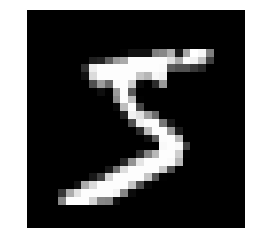

label: 5


In [7]:
# Run a magic to show images inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Show a datum!
x, t = train_val[0]  # Retrieve 0-th tuple of (data, label)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

### 1.1 Split a dataset into two sub datasets


To create a validation dataset, you need to split the `train_val` dataset object into two different dataset objects. Chainer has some useful functions to split dataset objects in some manner. If you want to split the dataset into a `train` dataset which has 50000 data out of 60000 and a `valid` dataset which has remaining 10000 data **randomly**, you can use `split_dataset_random` function as follows:

In [8]:
from chainer.datasets import split_dataset_random

train, valid = split_dataset_random(train_val, 50000, seed=0)

For reproducibility of this splitting, specifying a certain `seed` to the argument of `split_dataset_random` is recommended.

How many data are there in those datasets?

In [9]:
print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))

Training dataset size: 50000
Validation dataset size: 10000


## 2. Create an `Iterator`

We have finished preparing the dataset objects, but those are not so useful to use directly for training. Because neural nets usually are trained with the sotchastic gradient descent (SGD) which takes a set of data called **minibatch** to calculate the objective function to be minimized. Each datum in a minibatch is usually sampled from the training dataset randomly without replacement during an epoch.

To make a minibatch easily from the dataset object, Chainer provides some `Iterator` classes. An `Iterator` object is initialized with a dataset object, and you can retrieve the next minibatch by calling `next()` method of it. How many times all the data are retrieved, namely, epoch is stored in the `Iterator` object, so it's useful to write a training loop by yourself.

How to create an `Iterator` object is easy:

In [10]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

Here, three `Iterator`s for training, validation, and testing are created. `batchsize` is set to 128 in the beginning of this cell, so these `Iterator`s return a minibatch which has 128 data when you call `next()` method like this:

In [11]:
minibatch = train_iter.next()

print('Num of samples in the minibatch:', len(minibatch))

# Extract the first (image, label) pair in the minibatch
image, label = minibatch[0]

print('\nShape of the image:', image.shape)
print('Label of the first data in the minibatch:', label)

# Retrieve the next minibatch
minibatch = train_iter.next()

# Extract the first (image, label) pair in the minibatch
image, label = minibatch[0]

print('\nShape of the image:', image.shape)
print('Label of the first data in the minibatch:', label)

Num of samples in the minibatch: 128

Shape of the image: (784,)
Label of the first data in the minibatch: 1

Shape of the image: (784,)
Label of the first data in the minibatch: 1


**NOTE: What's `SerialIterator`**

`SerialIterator` is one of the `Iterator`s which Chainer provides, and it is the simplest one among all. It creates minibatches by taking data sequentially from the given dataset object. There are several options you can specify when making an `SerialIterator` object:

- `repeat`: If `True`, it infinitely loops over the dataset. Otherwise, it stops iteration at the end of the first epoch.
- `shuffle`: If `True`, the order of examples is shuffled at the beginning of each epoch. Otherwise, examples are extracted in the order of indexes.

You can also use `MultiprocesIterator` to eploit multi-core CPUs to make minibatches, and `MultithreadIterator` that uses threads instead of processes. Please take a look into the documentation page to know more about Chainer's `Iterator`s:

- [A list of `Iterator`s in Chainer](https://docs.chainer.org/en/stable/reference/iterators.html)

## 3. Write a neural network

Now, it's time to design a neural network with Chainer! In this section, let's see how to write a multi-layer perceptron which have 3 fully-connected layers. To train the network which clasifies images into a class out of 10 classes, the number of output units should be 10. We set the number of units in intermediate layers to 100 this time. In Chainer, a network is written using some classes like `Link`, `Function`, and `Chain` etc.:

### `Link` and `Function`

In Chainer, a layer in a neural network is either `Link` or `Function`.

- `Link` is parametric function which has learnable parameters
- `Function` is non-parametric function such as activations, four arithmetic operations, etc.

Networks are written in Chainer by combining `Link`s and `Function`s. You can find many parametric functions here: [`chainer.links` module](https://docs.chainer.org/en/stable/reference/links.html), and many non-parametric functions here [`chainer.functions` module](https://docs.chainer.org/en/stable/reference/functions.html). There is a common convention to access those modules easily by making shortcuts when importing them:

```
import chainer.links as L
import chainer.functions as F
```

It enables to use `Link`s and `Function`s like `L.Convolution2D(...)` and `F.relu(...)`, but this is not necessarily to be so.

### `Chain`

`Chain` is a class to bundle some learnable layers (`Link`s) together. `Link`s are learnable layers, so that they have learnable parameters. This means that the optimizer needs to find all of them to update their values during training (you can let a `Link` have "fixed parameters", though). To make finding all parameters to be updated in the network easily, `Chain` provides some functionalities to manage all learnable parameters in the network. For example, to collect all learnable parameters from `Link`s registered to the `Chain`, there is the `Chain.params()` method that returns all `Parameter` objects found under the `Chain`.

### Define your own network by inheriting `Chain`

The most common way to define a neural network in Chainer is to inherit `Chain` class and write down a new class for the network. In the constructor of the class, `self.init_scope()` is used to create a context where you can register child `Link`s (learnable layers) to the class (which is a `Chain` because it inherits `Chain` class). Then the optimizer can easily find all the learnable parameters in your network to train.

The forward pass computation of your network is written in `forward()` method of the class. If you write the forward computation in the method, that can be called through the `()` accessor, e.g., `output = net(data)`.

### How to run the network on GPU

`Chain` class provides `to_gpu()` method, so that you can send all the parameters to a GPU by calling it. `to_gpu()` takes a GPU ID where the network is sent to. Once you move the network to GPU memory, all the calculations defined in the `forward()` method is done on the GPU. If you specify -1 as the GPU ID, it means CPU.

### To ensure the reproducibility

There are some tips to ensure the reproducibility of network training. First, fix the random seeds for three modules:

In [12]:
import random
import numpy
import chainer

random.seed(0)
numpy.random.seed(0)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(0)

Second, if it is acceptable to slow down the calculation with cuDNN a bit, you can turn on a configuration `chainer.config.cudnn_deterministic` to use cuDNN without non-deterministic atomic operations.

### Multi-layer perceptron

Let's write down a multi-layer perceptron in Chainer!

In [13]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        
        # Register learnable layers
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        # Write the forward pass computation here
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # If you use CPU, specify -1 for gpu_id

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

That's it. Do you have any questions? If you want to customize this network using varied `Function`s and `Link`s, please check these documents to know what type of layers are provided in Chainer:

- [A list of `Function`s](https://docs.chainer.org/en/stable/reference/functions.html)
- [A list of learnable layers (`Link`s)](https://docs.chainer.org/en/stable/reference/links.html)

In the above document pages, many learnable/unlearnable functions which are commonly used in various types of neural networks, e.g., fully-connected layers, convolutional layers, LSTM, ReLU, and also many loss functions are also provided. All are differentiable because they are provided to be a part of your neural network!

Of course, you can define **your own original learnable layers and functions with NumPy (for CPU) and CuPy (for GPU)** very easily thanks to its "Define-by-Run" approach. Please check this document to see how to define your own functions in Chainer: [Define your own function](https://docs.chainer.org/en/stable/guides/functions.html).

**NOTE**

In the above network definition, the first linear layer (fully-connected layer) takes `None` as the first argument when being registered in the constructor. It means **the number of input units are determined at the first forward computation (=when an actual data is given to the network for the first time)**. Until then, the parameter is not allocated and not initialized. So, **you can use this network definition for arbitorary size of inputs without any change to the code**.

## 4. Choose an optimizer

To train the network defined above, it is necessary to setup an optimizer. Chainer provides various implementation of SGD such as Adam, RMSProp, MomentumSGD, AdaGrad, AdaDelta, ... Please check all the optimizers you can immediately use with Chainer here:

- [List of `Optimizer`s](https://docs.chainer.org/en/stable/reference/optimizers.html)

Here, we choose the simplest optimizer `optimizers.SGD` to traine the network on MNIST dataset. Once you choose an optimizer, it is required to give the network object to the optimizer class to initialize it.

In [14]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01).setup(net)

## 5. Start training

In multi-class classification problem, the softmax cross entropy is oftenly used as a loss function to train a neural net. It's calculated from a pair of a predicted label which is the output of the network and the correct label. The loss should be a scalar value in this case. Then, `F.softmax_cross_entropy()` function takes two inputs (the network output and the label) and returns a scalar value as a `Variable` object. This `Variable` object stores history of all the computations applied to the network input as a computational graph, so we can trace back the network architecture along with the actual calculation history to reconstruct the network actually used to make the output from the input. This way to determine the network structure is what we call "Define-by-Run". It enables us to write dynamic network architecture very easily compared to "Define-and-Run" style frameworks.

Once you get the loss `Variable`, the backward computation to calculate the gradients of all the parameters in the network can be done by just calling `Variable.backward()` method from that loss `Variable`. It starts gradient calculation by the chain rule for all the learnable parameters. The parameters are stored in the `Link`s as `Parameter` objects, but `Parameter` is a child class of `Variable`. And all the `Parameter`s will have `grad_var` property for the gradient after calling `backward()` method. Now the optimizer can update the parameter using the gradient with the update rule corresponding to the optimization method.

Repeating this flow is so-called "training loop". In summary, the following steps are performed in a single training iteration:

1. Give an input data `x` to the network and get the output `y`
2. Calculate the loss `Variable` from `y` and the correct labels `t`
3. Call the `backward()` method of the loss `Variable` to compute the gradients for all the learnable parameters in the network
4. Call `update()` method of the optimizer to update the parameters using gradients calculated in the step 3.

**NOTE: Various loss functions**

Chainer provides many loss functions for varios tasks. For example, if you want to train a network to solve a regression problem, you may want to calculate `F.mean_squared_error()` or `F.mean_absolute_error()` etc. Please check this document to see what types of loss functions are provided in Chainer:

- [Loss functions available in Chainer](https://docs.chainer.org/en/stable/reference/functions.html#loss-functions)

### The training loop

In [15]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # ---------- 1 iteration of training ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)
    
    # Create a prediction
    y = net(x)

    # Calculate the loss
    loss = F.softmax_cross_entropy(y, t)

    # Calculate the gradients
    net.cleargrads()
    loss.backward()

    # Update all the learnable parameters
    optimizer.update()
    # ----------------- to here -------------------

    # Every 1 epoch, check the generalization ability of the
    # network by measuring the accuracy on the validation data
    if train_iter.is_new_epoch:  # when this iteration was the final iteration in this epoch

        # Show the loss value
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        valid_losses = []
        valid_accuracies = []
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch, gpu_id)

            # Create a prediction on the validation data
            with chainer.using_config('train', False), \
                    chainer.using_config('enable_backprop', False):
                y_valid = net(x_valid)

            # Calculate the loss
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(to_cpu(loss_valid.array))

            # Calculate the accuracy
            accuracy = F.accuracy(y_valid, t_valid)
            accuracy.to_cpu()
            valid_accuracies.append(accuracy.array)
                        
            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))
        
# Evaluation of the network on the test dataset
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch, gpu_id)

    # Create a prediction on the test data
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = net(x_test)

    # Calculate the accuracy
    accuracy = F.accuracy(y_valid, t_valid)
    accuracy.to_cpu()
    test_accuracies.append(accuracy.array)

    if test_iter.is_new_epoch:
        test_iter.reset()
        break

print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

epoch:01 train_loss:0.9192 val_loss:0.9769 val_accuracy:0.8034
epoch:02 train_loss:0.5859 val_loss:0.5341 val_accuracy:0.8652
epoch:03 train_loss:0.5736 val_loss:0.4262 val_accuracy:0.8821
epoch:04 train_loss:0.4714 val_loss:0.3747 val_accuracy:0.8935
epoch:05 train_loss:0.3406 val_loss:0.3462 val_accuracy:0.8997
epoch:06 train_loss:0.3153 val_loss:0.3255 val_accuracy:0.9089
epoch:07 train_loss:0.3463 val_loss:0.3098 val_accuracy:0.9124
epoch:08 train_loss:0.3130 val_loss:0.2983 val_accuracy:0.9152
epoch:09 train_loss:0.2293 val_loss:0.2896 val_accuracy:0.9177
epoch:10 train_loss:0.3513 val_loss:0.2788 val_accuracy:0.9212
test_accuracy:0.9375
